# RetinaNet Inference - Visual Walkthrough

In [350]:
import os
import sys

import torch
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from torchvision import transforms

from src.retinanet import retinanet_resnet50_fpn
from src.model_utils import COCO_LABELS

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [351]:
np.random.seed(42)
COLORS = np.random.uniform(size=(len(COCO_LABELS), 3))

## Load a pretrained RetinaNet model 

In [352]:
# load pretrained model
retinanet = retinanet_resnet50_fpn(
    pretrained=True, pretrained_backbone=True, nms_off=False
)

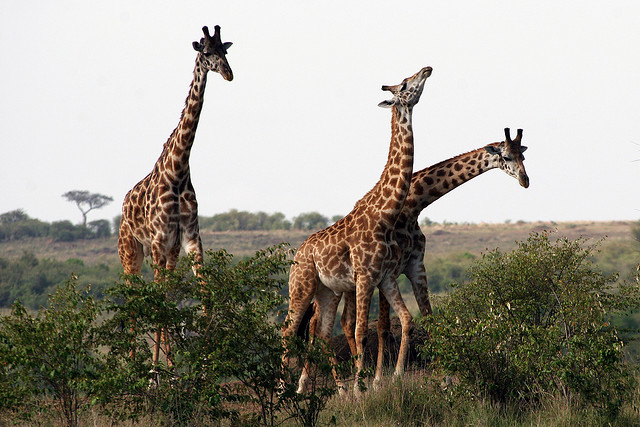

In [353]:
# load an image
test_img = Image.open("images/soccer_img.jpg")
test_img = Image.open("images/giraffe.jpg")
test_img

In [354]:
# define transform
transform = transforms.Compose(
    [
        transforms.ToTensor(),
    ]
)

In [355]:
def predict(model, image, transform, detection_threshold):
    """
    Use a trained Pytorch detection model to make inference on an input image

    Args:
        model - Pytorch detetection model
        image - PIL image as RGB format
        transform - torchvision Compose object
        detection_threshold - confidence score for anchorbox predictions to be kept

    Returns:
        outputs - dict containing boxes, scores, labels for predictions


    """

    if model.training:
        model.eval()

    image = transform(image).unsqueeze(0)
    outputs = model(image)[0]

    idxs = np.where(outputs["scores"] > detection_threshold)

    boxes = outputs["boxes"][idxs]
    scores = outputs["scores"][idxs]
    labels = outputs["labels"][idxs]
    outputs = {"boxes": boxes, "scores": scores, "labels": labels}

    return outputs

In [356]:
%time

a = predict(
    model=retinanet, image=test_img, transform=transform, detection_threshold=0.9
)

CPU times: user 5 µs, sys: 1 µs, total: 6 µs
Wall time: 28.8 µs


### View predictions from an image

In [347]:
def convert_bb_spec(xmin, ymin, xmax, ymax):
    """
    Convert a bounding box representation
    
    """

    x = xmin
    y = ymin
    width = xmax - xmin
    height = ymax - ymin

    return x, y, width, height


def plot_predictions(image, outputs, label_map, nms_off=False):
    """
    Overlay bounding box predictions on an image

    Args:
        image - PIL image as RGB format
        outputs - boxes, scores, labels output from predict()
        label_map - list mapping of idx to label name
        nms_off - indicates if visualization is with or without NMS

    """

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    np.random.seed(24)
    colors = np.random.uniform(size=(len(label_map), 3))
    boxes, scores, labels = outputs.values()

    for i, box in enumerate(boxes):

        x, y, width, height = convert_bb_spec(*box)
        top = y + height

        patch = patches.Rectangle(
            (x, y),
            width,
            height,
            edgecolor=colors[labels[i]],
            linewidth=1,
            facecolor="none",
        )
        ax.add_patch(patch)

        if nms_off:
            continue

        ax.text(
            x,
            y,
            label_map[labels[i]],
            color=colors[labels[i]],
            fontweight="semibold",
            horizontalalignment="left",
            verticalalignment="bottom",
        )
        ax.text(
            x + width,
            y + height,
            round(scores[i].item(), 2),
            color=colors[labels[i]],
            fontweight="bold",
            horizontalalignment="right",
            verticalalignment="top",
        )

    plt.axis("off")
    plt.show()

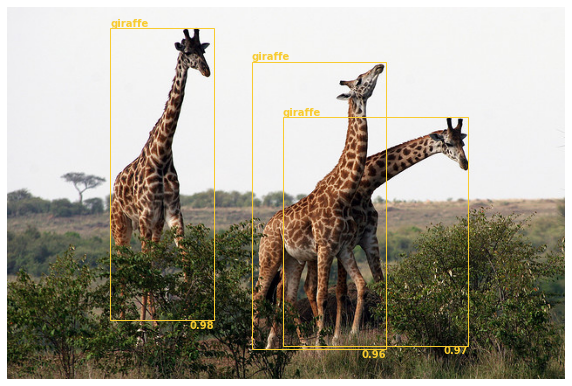

In [348]:
plot_predictions(test_img, a, COCO_LABELS, False)

In [336]:
from torchvision import datasets

In [339]:
datasets.coco.CocoDetection.extra_repr()

TypeError: extra_repr() missing 1 required positional argument: 'self'

## Anchor Generator

In [11]:
from torchvision.models.detection.anchor_utils import AnchorGenerator

In [12]:
anchor_sizes = tuple(
    (x, int(x * 2 ** (1.0 / 3)), int(x * 2 ** (2.0 / 3)))
    for x in [32, 64, 128, 256, 512]
)
aspect_ratios = ((0.5, 1.0, 2.0),) * len(anchor_sizes)
anchor_generator = AnchorGenerator(anchor_sizes, aspect_ratios)

In [13]:
anchor_sizes

((32, 40, 50),
 (64, 80, 101),
 (128, 161, 203),
 (256, 322, 406),
 (512, 645, 812))

In [14]:
aspect_ratios

((0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0),
 (0.5, 1.0, 2.0))

In [15]:
anchor_generator.num_anchors_per_location()

[9, 9, 9, 9, 9]

In [16]:
retinanet.viz_artifacts["anchors"]

[tensor([[ -23.,  -11.,   23.,   11.],
         [ -28.,  -14.,   28.,   14.],
         [ -35.,  -18.,   35.,   18.],
         ...,
         [ 881.,  322., 1243., 1046.],
         [ 834.,  228., 1290., 1140.],
         [ 775.,  110., 1349., 1258.]])]

In [17]:
retinanet.viz_artifacts["anchors"][0].shape

torch.Size([177678, 4])

In [18]:
def plot_anchors(image, boxes, sample):
    """
    Overlay anchor boxes on the original image

    Args:
        image - PIL image as RGB format
        boxes - Tensor(N,4) of all anchor box specs
        sample - percentage of anchorboxes to randomly select for visualization

    """

    fig, ax = plt.subplots(1, figsize=(10, 10))
    ax.imshow(image)

    num_samples = int(sample * boxes.shape[0])
    sample_idxs = torch.randint(low=0, high=boxes.shape[0], size=(num_samples,))
    boxes = boxes[sample_idxs]

    for i, box in enumerate(boxes):

        x, y, width, height = convert_bb_spec(*box)
        top = y + height

        patch = patches.Rectangle(
            (x, y),
            width,
            height,
            edgecolor="red",
            linewidth=1,
            facecolor="none",
        )
        ax.add_patch(patch)

    plt.axis("off")
    plt.show()

CPU times: user 3 µs, sys: 0 ns, total: 3 µs
Wall time: 5.72 µs


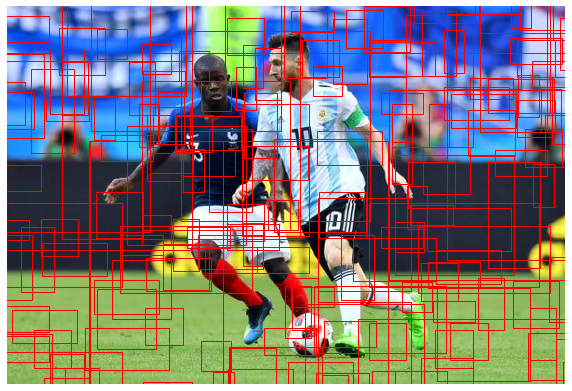

In [19]:
%time
plot_anchors(test_img, retinanet.viz_artifacts["anchors"][0], 0.003)

## Detections before NMS

In [18]:
# load pretrained model
retinanet_nms_off = retinanet_resnet50_fpn(
    pretrained=True, pretrained_backbone=True, nms_off=True
)

In [19]:
%time

b = predict(
    model=retinanet_nms_off,
    image=test_img,
    transform=transform,
    detection_threshold=0.9,
)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.87 µs


In [313]:
type(test_img)

PIL.JpegImagePlugin.JpegImageFile

In [314]:
test_img.size

(640, 427)

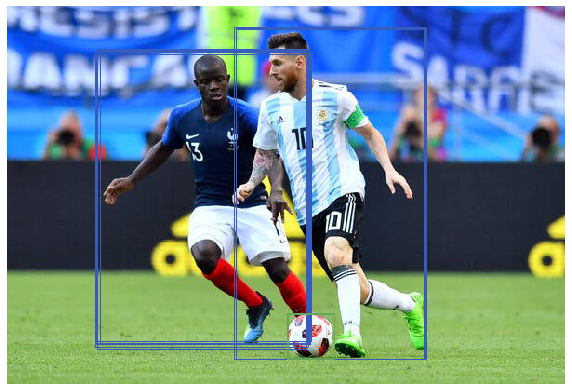

In [21]:
plot_predictions(test_img, b, COCO_LABELS, True)

### Visualize Feature Maps

In [274]:
def sample_feature_maps(features, n):
    '''
    Given a list of features from model.backbone, this function randomly samples N
    feature maps from each FPN layer.
    
    Args:
        features (List[Tensor]) - list of features from model.backbone
        n (int) - number of samples per layer
        
    Returns:
        samples (dict) - a dict containing N feature maps per layer
    
    '''
    np.random.seed(42)
    
    samples = {}
    for i, plevel in enumerate(features):
        
        maps = plevel.squeeze(0).detach().numpy()
        channel_idx = np.random.choice(range(maps.shape[0]), n)
        samples[i] = maps[channel_idx,:,:]
        
    return samples
    
def plot_feature_samples(samples):
    '''
    Given a dict of samples from sample_feature_maps(), this function plots
    them in a organized columnar fashion.
    
    '''
    
    rows = samples[0].shape[0]
    columns = len(samples)
    
    fig = plt.figure(figsize=(16,20))
    grid = plt.GridSpec(nrows=rows, ncols=columns, figure=fig, wspace = 0.3, hspace = 0.1)
        
    for i, layer in samples.items():
        for j in range(rows):
            ax = plt.subplot(grid[j,i])
            ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)
            
            if j == 0:
                ax.set_title(f'P{i+3}: {layer.shape[1]} x {layer.shape[2]}')
                
            ax.imshow(layer[j,:,:], aspect='auto')
            
    fig.suptitle('Feature Maps per FPN Level')
    
    return fig

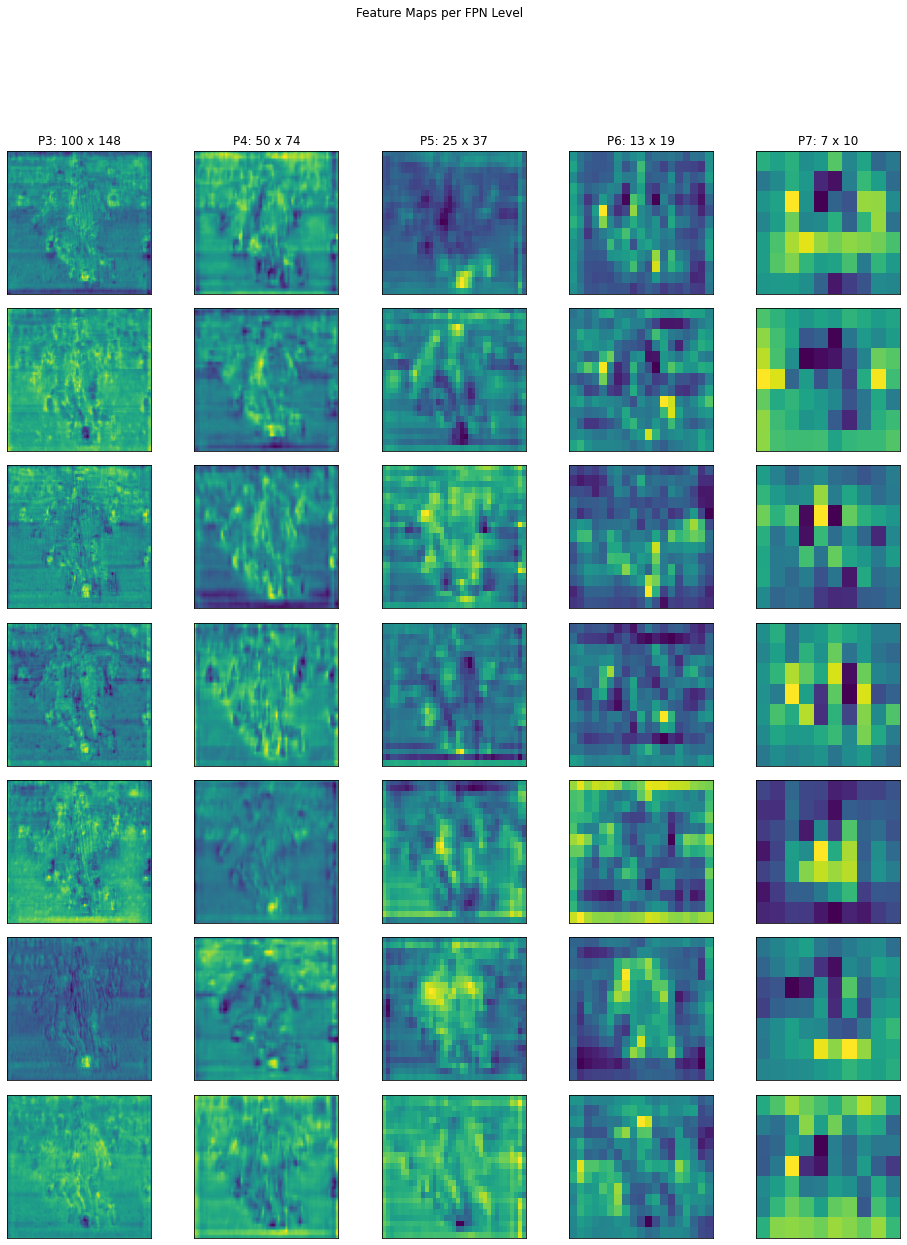

In [275]:
a = plot_feature_samples(samples)

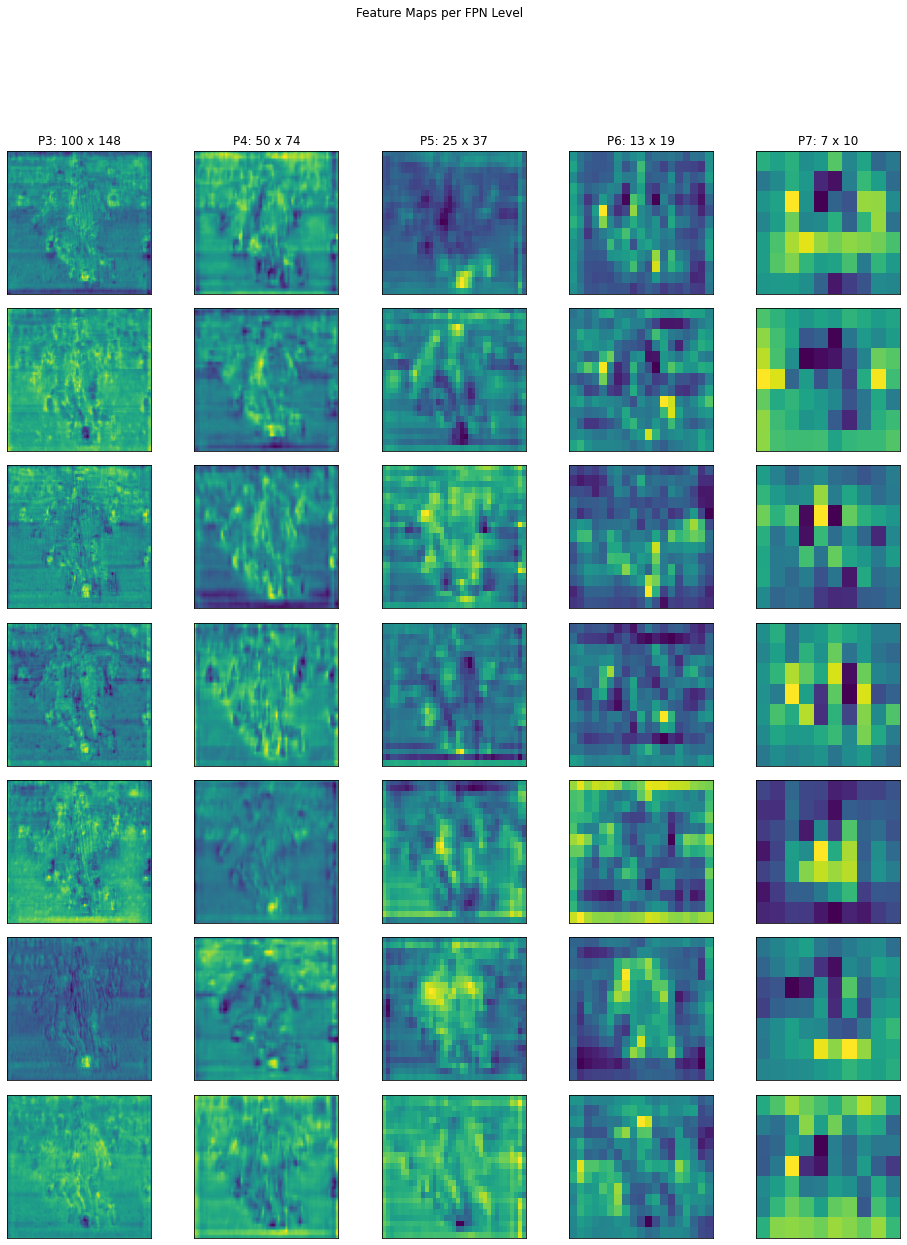

In [277]:
a

### Fix Feature Map

In [357]:
from src.app_utils import sample_feature_maps, plot_feature_samples

In [524]:
def plot_feature_samples(samples):
    """
    Given a dict of samples from sample_feature_maps(), this function plots
    them in a organized columnar fashion.

    """

    rows = samples[0].shape[0]
    columns = len(samples)
    
    
#     figsize = (samples[0].shape[2]/10, samples[0].shape[1]/10*1.75)
    figsize = (12,12)
    fig = plt.figure(figsize=figsize, frameon=False)
    grid = plt.GridSpec(nrows=rows, ncols=columns, figure=fig, wspace=0.15, hspace=0.1)

    for i, layer in samples.items():
        for j in range(rows):
            ax = plt.subplot(grid[j, i])
            ax.tick_params(bottom=False, labelbottom=False, left=False, labelleft=False)

            if j == 0:
                ax.set_title(f"P{i+3}: {layer.shape[1]} x {layer.shape[2]}")

            ax.imshow(layer[j, :, :], aspect="auto")

    return fig

In [525]:
samples = sample_feature_maps(retinanet.viz_artifacts['features'], 7)

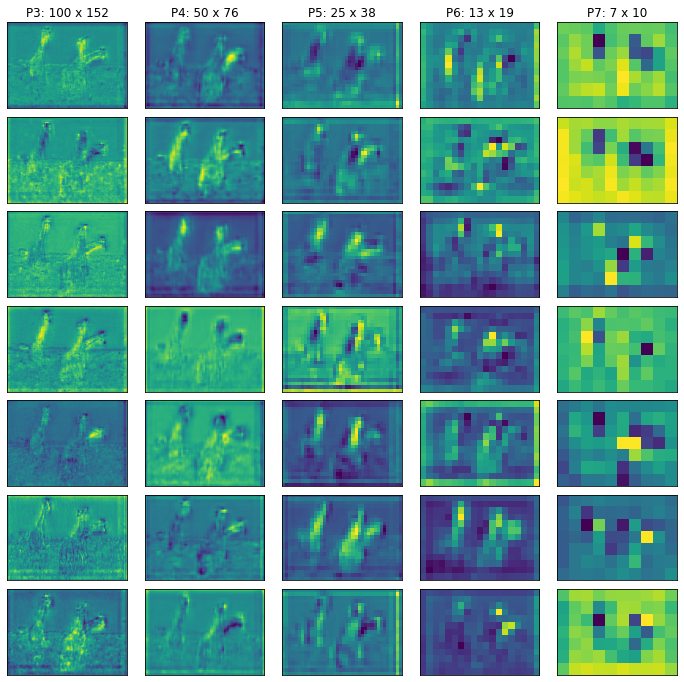

In [526]:
fig = plot_feature_samples(samples)

In [527]:
fig.savefig('test.png', pad_inches=0)

In [504]:
image = Image.open('images/giraffe.jpg')

In [505]:
image.

(640, 427)